# 파일 업로드

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving cow_csv.zip to cow_csv.zip
User uploaded file "cow_csv.zip" with length 8685509 bytes


In [3]:
!unzip -q cow_csv.zip # 압축파일 이름 확인

In [4]:
!ls

cow  cow_csv.zip  sample_data


In [5]:
!ls cow

'월별 lely 활동량 (24.01).csv'	'월별 lely 활동량 (24.07).csv'
'월별 lely 활동량 (24.02).csv'	'월별 lely 활동량 (24.08).csv'
'월별 lely 활동량 (24.03).csv'	'월별 lely 활동량 (24.09).csv'
'월별 lely 활동량 (24.04).csv'	'월별 lely 활동량 (24.10).csv'
'월별 lely 활동량 (24.05).csv'	'월별 lely 활동량 (24.11).csv'
'월별 lely 활동량 (24.06).csv'	'월별 lely 활동량 (24.12)~12.22.csv'


In [5]:
# -*- coding: utf-8 -*-
import pandas as pd, numpy as np, glob, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix

csv_list = glob.glob('./cow/*.csv')
dfs = []
for p in csv_list:
    df = pd.read_csv(p, low_memory=False)
    if '시간' in df.columns: df.rename(columns={'시간':'시간(시:분)'}, inplace=True)
    cols = ['개체 번호','날짜','시간(시:분)','활동량','전체 반추 시간(분)','발정 확률']
    df = df[cols].dropna()
    df['datetime'] = pd.to_datetime(df['날짜'] + ' ' + df['시간(시:분)'])
    df = df[['개체 번호','datetime','활동량','전체 반추 시간(분)','발정 확률']]
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)
data.sort_values(['개체 번호','datetime'], inplace=True)

In [6]:
print(data.shape) # (504678, 5)
print("개체 수:", data['개체 번호'].nunique())
print("기간:", data['datetime'].min(), "→", data['datetime'].max())
print("1두 샘플 간격:", data.sort_values('datetime').groupby('개체 번호')['datetime'].diff().median())

(504678, 5)
개체 수: 185
기간: 2024-01-01 00:00:00 → 2024-12-22 22:00:00
1두 샘플 간격: 0 days 02:00:00


In [7]:
data['개체 번호'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 101, 102, 104, 105, 106, 107, 108,
       110, 111, 112, 113, 114, 116, 117, 118, 121, 122, 124, 125, 128,
       129, 131, 132, 133, 136, 137, 138, 139, 140, 143, 144, 145, 146,
       149, 150, 151, 153, 155, 156, 157, 158, 159, 161, 162, 163, 164,
       166, 167, 170, 199, 201, 203, 204, 205, 208, 211, 214, 215, 216,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 615, 65

In [8]:
FEATURES = ['활동량','전체 반추 시간(분)']
POS_THRESH = 25
def make_sequences_by_cow(df, seq_len=12): #step 설정 -> 1 step 2시간 -> 12 step 24시간
    Xs, ys, cows = [], [], []
    for cid, g in df.groupby('개체 번호'):
        g = g.sort_values('datetime')
        vals = g[FEATURES + ['발정 확률']].to_numpy()
        if len(vals) <= seq_len: continue
        # 개체별 스케일링: 입력(2개 feature)만 표준화. 타깃은 원스케일 유지.
        scaler = StandardScaler()
        feats = scaler.fit_transform(vals[:, :2])
        prob  = vals[:, 2]
        for i in range(len(vals) - seq_len):
            x = feats[i:i+seq_len, :]             # (seq, 2)
            # y= prob[i+seq_len]         # 다음 시점 확률
            y_next_prob = prob[i+seq_len]
            y = 1.0 if y_next_prob >= POS_THRESH else 0.0
            Xs.append(x); ys.append(y); cows.append(cid)
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32), np.array(cows)

X, y, cows = make_sequences_by_cow(data, 12)


In [9]:
unique_ids = np.random.permutation(np.unique(cows))
n_train = int(len(unique_ids)*0.8)
train_ids, val_ids = set(unique_ids[:n_train]), set(unique_ids[n_train:])

train_mask = np.isin(cows, list(train_ids))
val_mask   = np.isin(cows, list(val_ids))

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]

class CowDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)        # (N, seq, 2)
        self.y = torch.from_numpy(y).unsqueeze(1)  # (N, 1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

BATCH = 24
train_loader = DataLoader(CowDS(X_train, y_train), batch_size=BATCH, shuffle=False)
val_loader   = DataLoader(CowDS(X_val,   y_val),   batch_size=BATCH, shuffle=False)

In [35]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class LSTMClassifier(nn.Module):
    def __init__(self, input_size=2, hidden=32, layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden, layers)
        self.fc   = nn.Linear(hidden, 1)
    def forward(self, x):
        # h0 = torch.zeros(1, x.size(0), 32).to(DEVICE)
        # c0 = torch.zeros(1, x.size(0), 32).to(DEVICE)

        out, _ = self.lstm(x)        # (B, T, H)
        last = out[:, -1, :]         # (B, H)
        logit = self.fc(last)        # (B, 1)
        return logit


In [36]:
LR = 1e-3
model = LSTMClassifier().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total = 0.0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb = xb.to(DEVICE).float()        # (B, 12, 2)
            yb = yb.to(DEVICE).float().view(-1,1)  # (B,1)
            if train: optimizer.zero_grad(set_to_none=True)
            logit = model(xb)                 # (B,1)
            loss  = criterion(logit, yb)
            if train:
                loss.backward()
                optimizer.step()
            total += loss.item()
    return total / max(len(loader), 1)

train_hist, val_hist = [], []
EPOCHS = 20
for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader, False)
    train_hist.append(tr); val_hist.append(va)
    print(f"Epoch {ep:02d} | train={tr:.4f}  val={va:.4f}")

Epoch 01 | train=0.0424  val=0.0263
Epoch 02 | train=0.0351  val=0.0250
Epoch 03 | train=0.0337  val=0.0244
Epoch 04 | train=0.0329  val=0.0244
Epoch 05 | train=0.0324  val=0.0244
Epoch 06 | train=0.0319  val=0.0243
Epoch 07 | train=0.0315  val=0.0241
Epoch 08 | train=0.0311  val=0.0240
Epoch 09 | train=0.0307  val=0.0239
Epoch 10 | train=0.0304  val=0.0239
Epoch 11 | train=0.0300  val=0.0238
Epoch 12 | train=0.0297  val=0.0238
Epoch 13 | train=0.0294  val=0.0240
Epoch 14 | train=0.0291  val=0.0241
Epoch 15 | train=0.0287  val=0.0242
Epoch 16 | train=0.0287  val=0.0241
Epoch 17 | train=0.0286  val=0.0245
Epoch 18 | train=0.0282  val=0.0246
Epoch 19 | train=0.0280  val=0.0245
Epoch 20 | train=0.0274  val=0.0245


[VAL] PR-AUC = 0.6397 | ROC-AUC = 0.9697
[VAL] Best F1 = 0.6073 @ thr = 0.397
Confusion matrix:
 [[100809    221]
 [   498    556]]
              precision    recall  f1-score   support

   No Estrus     0.9951    0.9978    0.9964    101030
      Estrus     0.7156    0.5275    0.6073      1054

    accuracy                         0.9930    102084
   macro avg     0.8553    0.7627    0.8019    102084
weighted avg     0.9922    0.9930    0.9924    102084



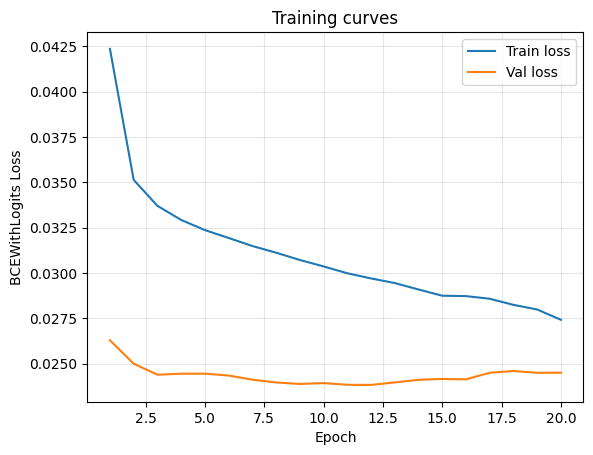

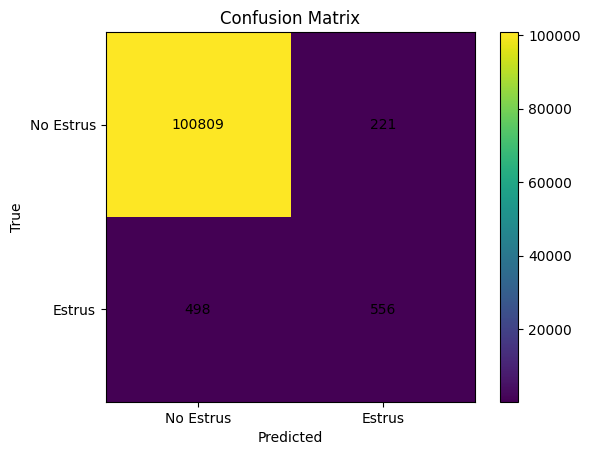

In [37]:

model.eval()
import numpy as np
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix, roc_curve, roc_auc_score

all_logits, all_y = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        lg = model(xb.to(DEVICE)).cpu().numpy().ravel()
        all_logits.append(lg); all_y.append(yb.numpy().ravel())
logits = np.concatenate(all_logits)
y_true = np.concatenate(all_y)
y_prob = 1/(1+np.exp(-logits))  # 시그모이드

# PR 곡선 & 최적 임계값(F1 기준)
prec, rec, ths = precision_recall_curve(y_true, y_prob)
f1s = 2*prec*rec/(prec+rec+1e-9)
best_idx = int(np.nanargmax(f1s))
best_thr = ths[best_idx] if best_idx < len(ths) else 0.5
pr_auc = auc(rec, prec)

# ROC (참고용)
fpr, tpr, roct = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

y_pred = (y_prob >= best_thr).astype(int)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=['No Estrus','Estrus'], digits=4)

print(f"[VAL] PR-AUC = {pr_auc:.4f} | ROC-AUC = {roc_auc:.4f}")
print(f"[VAL] Best F1 = {f1s[best_idx]:.4f} @ thr = {best_thr:.3f}")
print("Confusion matrix:\n", cm)
print(report)


import matplotlib.pyplot as plt


plt.figure()
plt.plot(range(1, len(train_hist)+1), train_hist, label="Train loss")
plt.plot(range(1, len(val_hist)+1),   val_hist,   label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("BCEWithLogits Loss"); plt.title("Training curves")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()


# 혼동행렬(문자열 주석 포함)
def plot_confusion_matrix(cm, class_names=('No Estrus','Estrus')):
    plt.figure()
    ax = plt.gca()
    im = ax.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.colorbar(im)
    plt.show()

plot_confusion_matrix(cm)


In [38]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit


groups = cows  # 각 샘플의 개체 번호
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, y_train, cows_train = X[train_idx], y[train_idx], cows[train_idx]
X_val,   y_val,   cows_val   = X[val_idx],   y[val_idx],   cows[val_idx]

# 1) 학습 세트에만 언더샘플링 적용
rng = np.random.default_rng(42)
idx0 = np.where(y_train == 0)[0]
idx1 = np.where(y_train == 1)[0]

# 타깃 비율: 동일하게 맞추기 (필요하면 ratio 조절)
n1 = len(idx1)
n0_keep = min(len(idx0), n1)    # 동수로 맞춤
idx0_sel = rng.choice(idx0, size=n0_keep, replace=False)

sel = np.concatenate([idx0_sel, idx1])
rng.shuffle(sel)

X_train_bal = X_train[sel]
y_train_bal = y_train[sel]
cows_train_bal = cows_train[sel]

# 2) (선택) 검증 세트는 원 분포 유지. 필요하면 셔플만
order_val = rng.permutation(len(X_val))
X_val = X_val[order_val]
y_val = y_val[order_val]

# 3) PyTorch Dataset (float32, y: (N,1))
import torch
from torch.utils.data import Dataset, DataLoader

class CowDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)               # (N, T, F)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # (N, 1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

BATCH = 24
train_loader = DataLoader(CowDS(X_train_bal, y_train_bal), batch_size=BATCH,
                          shuffle=True, pin_memory=True, num_workers=2)
val_loader   = DataLoader(CowDS(X_val,       y_val),       batch_size=BATCH,
                          shuffle=False, pin_memory=True, num_workers=2)

LR = 1e-3
model = LSTMClassifier().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total = 0.0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb = xb.to(DEVICE).float()        # (B, 12, 2)
            yb = yb.to(DEVICE).float().view(-1,1)  # (B,1)
            if train: optimizer.zero_grad(set_to_none=True)
            logit = model(xb)                 # (B,1)
            loss  = criterion(logit, yb)
            if train:
                loss.backward()
                optimizer.step()
            total += loss.item()
    return total / max(len(loader), 1)

train_hist, val_hist = [], []
EPOCHS = 20
for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader, False)
    train_hist.append(tr); val_hist.append(va)
    print(f"Epoch {ep:02d} | train={tr:.4f}  val={va:.4f}")


Epoch 01 | train=0.4940  val=0.4541
Epoch 02 | train=0.4366  val=0.4356
Epoch 03 | train=0.4341  val=0.4023
Epoch 04 | train=0.4339  val=0.4090
Epoch 05 | train=0.4321  val=0.4032
Epoch 06 | train=0.4309  val=0.3706
Epoch 07 | train=0.4313  val=0.3884
Epoch 08 | train=0.4292  val=0.4667
Epoch 09 | train=0.4290  val=0.4398
Epoch 10 | train=0.4296  val=0.3716
Epoch 11 | train=0.4290  val=0.3847
Epoch 12 | train=0.4288  val=0.4163
Epoch 13 | train=0.4281  val=0.3872
Epoch 14 | train=0.4280  val=0.3528
Epoch 15 | train=0.4274  val=0.3924
Epoch 16 | train=0.4273  val=0.4614
Epoch 17 | train=0.4281  val=0.3302
Epoch 18 | train=0.4272  val=0.3966
Epoch 19 | train=0.4270  val=0.4163
Epoch 20 | train=0.4261  val=0.4503


[VAL] PR-AUC = 0.2459 | ROC-AUC = 0.8780
[VAL] Best F1 = 0.3244 @ thr = 0.942
Confusion matrix:
 [[99591   604]
 [  780   332]]
              precision    recall  f1-score   support

   No Estrus     0.9922    0.9940    0.9931    100195
      Estrus     0.3547    0.2986    0.3242      1112

    accuracy                         0.9863    101307
   macro avg     0.6735    0.6463    0.6587    101307
weighted avg     0.9852    0.9863    0.9858    101307



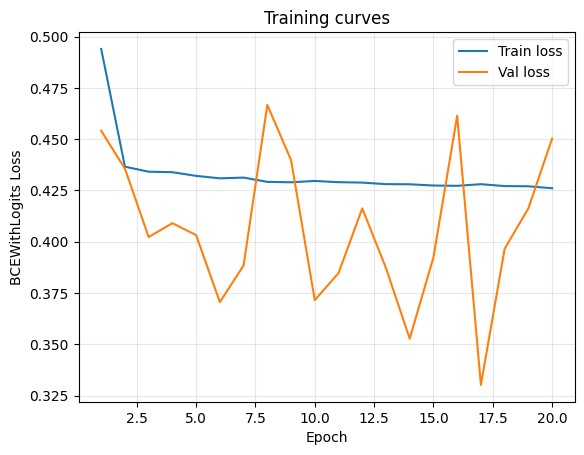

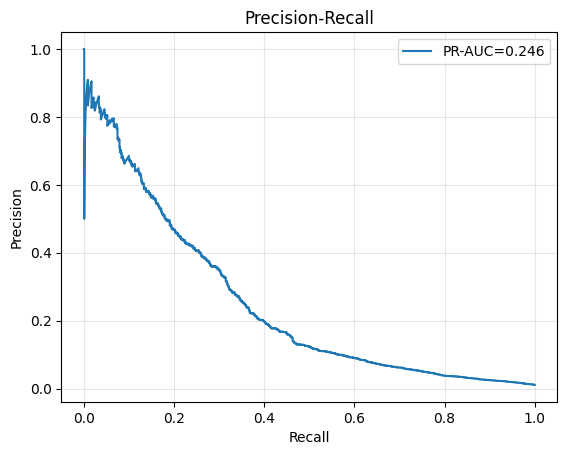

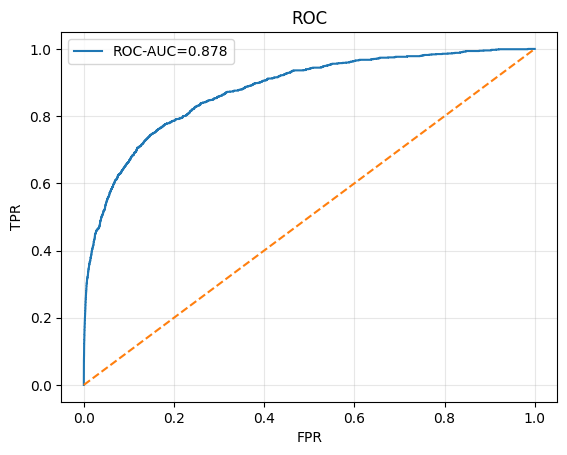

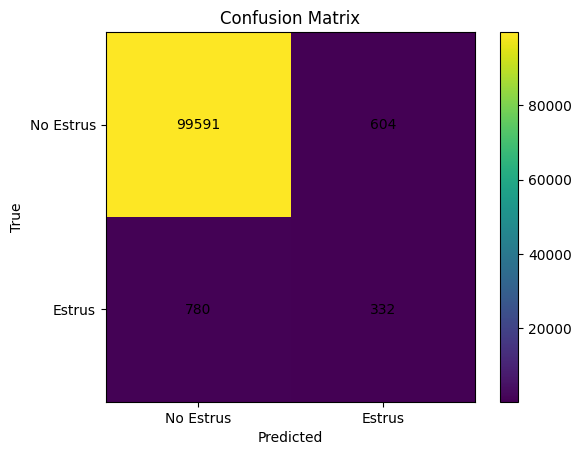

In [40]:
model.eval()

import numpy as np
import torch
from sklearn.metrics import (
    classification_report, precision_recall_curve, auc,
    confusion_matrix, roc_curve, roc_auc_score
)

all_logits, all_y = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        lg = model(xb)                       # (B,1) logits
        all_logits.append(lg.detach().cpu().numpy().ravel())
        all_y.append(yb.detach().cpu().numpy().ravel())

logits = np.concatenate(all_logits)          # (N,)
y_true = np.concatenate(all_y)               # (N,)
y_prob = 1.0 / (1.0 + np.exp(-logits))       # sigmoid(logits)

# ----- PR 곡선 & 최적 임계값(F1 기준) -----
prec, rec, ths = precision_recall_curve(y_true, y_prob)
# sklearn은 prec/rec 길이 = len(ths)+1 이므로 thresholds에 맞춰 F1 계산
f1s_thr = 2 * prec[1:] * rec[1:] / (prec[1:] + rec[1:] + 1e-9)
best_idx = int(np.nanargmax(f1s_thr))
best_thr = float(ths[best_idx])
best_f1  = float(f1s_thr[best_idx])
pr_auc   = auc(rec, prec)

# ----- ROC (단일 클래스일 경우 예외 처리) -----
try:
    roc_auc = roc_auc_score(y_true, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
except ValueError:
    roc_auc = float("nan")
    fpr, tpr = np.array([0,1]), np.array([0,1])  # placeholder

# ----- 이진 결정 -----
y_pred = (y_prob >= best_thr).astype(int)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(
    y_true, y_pred,
    target_names=['No Estrus','Estrus'],
    digits=4, zero_division=0
)

print(f"[VAL] PR-AUC = {pr_auc:.4f} | ROC-AUC = {roc_auc:.4f}")
print(f"[VAL] Best F1 = {best_f1:.4f} @ thr = {best_thr:.3f}")
print("Confusion matrix:\n", cm)
print(report)

# ===== (시각화) =====
import matplotlib.pyplot as plt

# (1) 학습 곡선
plt.figure()
plt.plot(range(1, len(train_hist)+1), train_hist, label="Train loss")
plt.plot(range(1, len(val_hist)+1),   val_hist,   label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("BCEWithLogits Loss"); plt.title("Training curves")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# (2) 혼동행렬
def plot_confusion_matrix(cm, class_names=('No Estrus','Estrus')):
    plt.figure()
    ax = plt.gca()
    im = ax.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.colorbar(im)
    plt.show()

plot_confusion_matrix(cm)


In [ ]:
# 스텝 간격(시간) 추정: 개체별 시계열 간격의 중앙값들을 모아 전체 중앙값
hours_per_step = (data.sort_values(['개체 번호','datetime'])
                    .groupby('개체 번호')['datetime'].diff()
                    .dropna()
                    .dt.total_seconds().median()) / 3600
print(f"추정 간격 ≈ {hours_per_step:.2f} 시간/스텝")

# 자주 나오는 간격(분)도 같이 확인(이상치/결측 체크)
gap_counts = (data.sort_values(['개체 번호','datetime'])
                .groupby('개체 번호')['datetime'].diff()
                .dropna()
                .dt.total_seconds().div(60).round().astype(int)

                .value_counts().sort_index())
print("상위 간격(분) 빈도:\n", gap_counts.head(5))
print(gap_counts[(gap_counts.index >= 240) & (gap_counts.index <= 360)].sum())

In [ ]:
2시간 간격이 아닌 개체가 존재한다!!
긴 공백은 6804시간...?